In [ ]:
from qiskit import QuantumCircuit,QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
import random


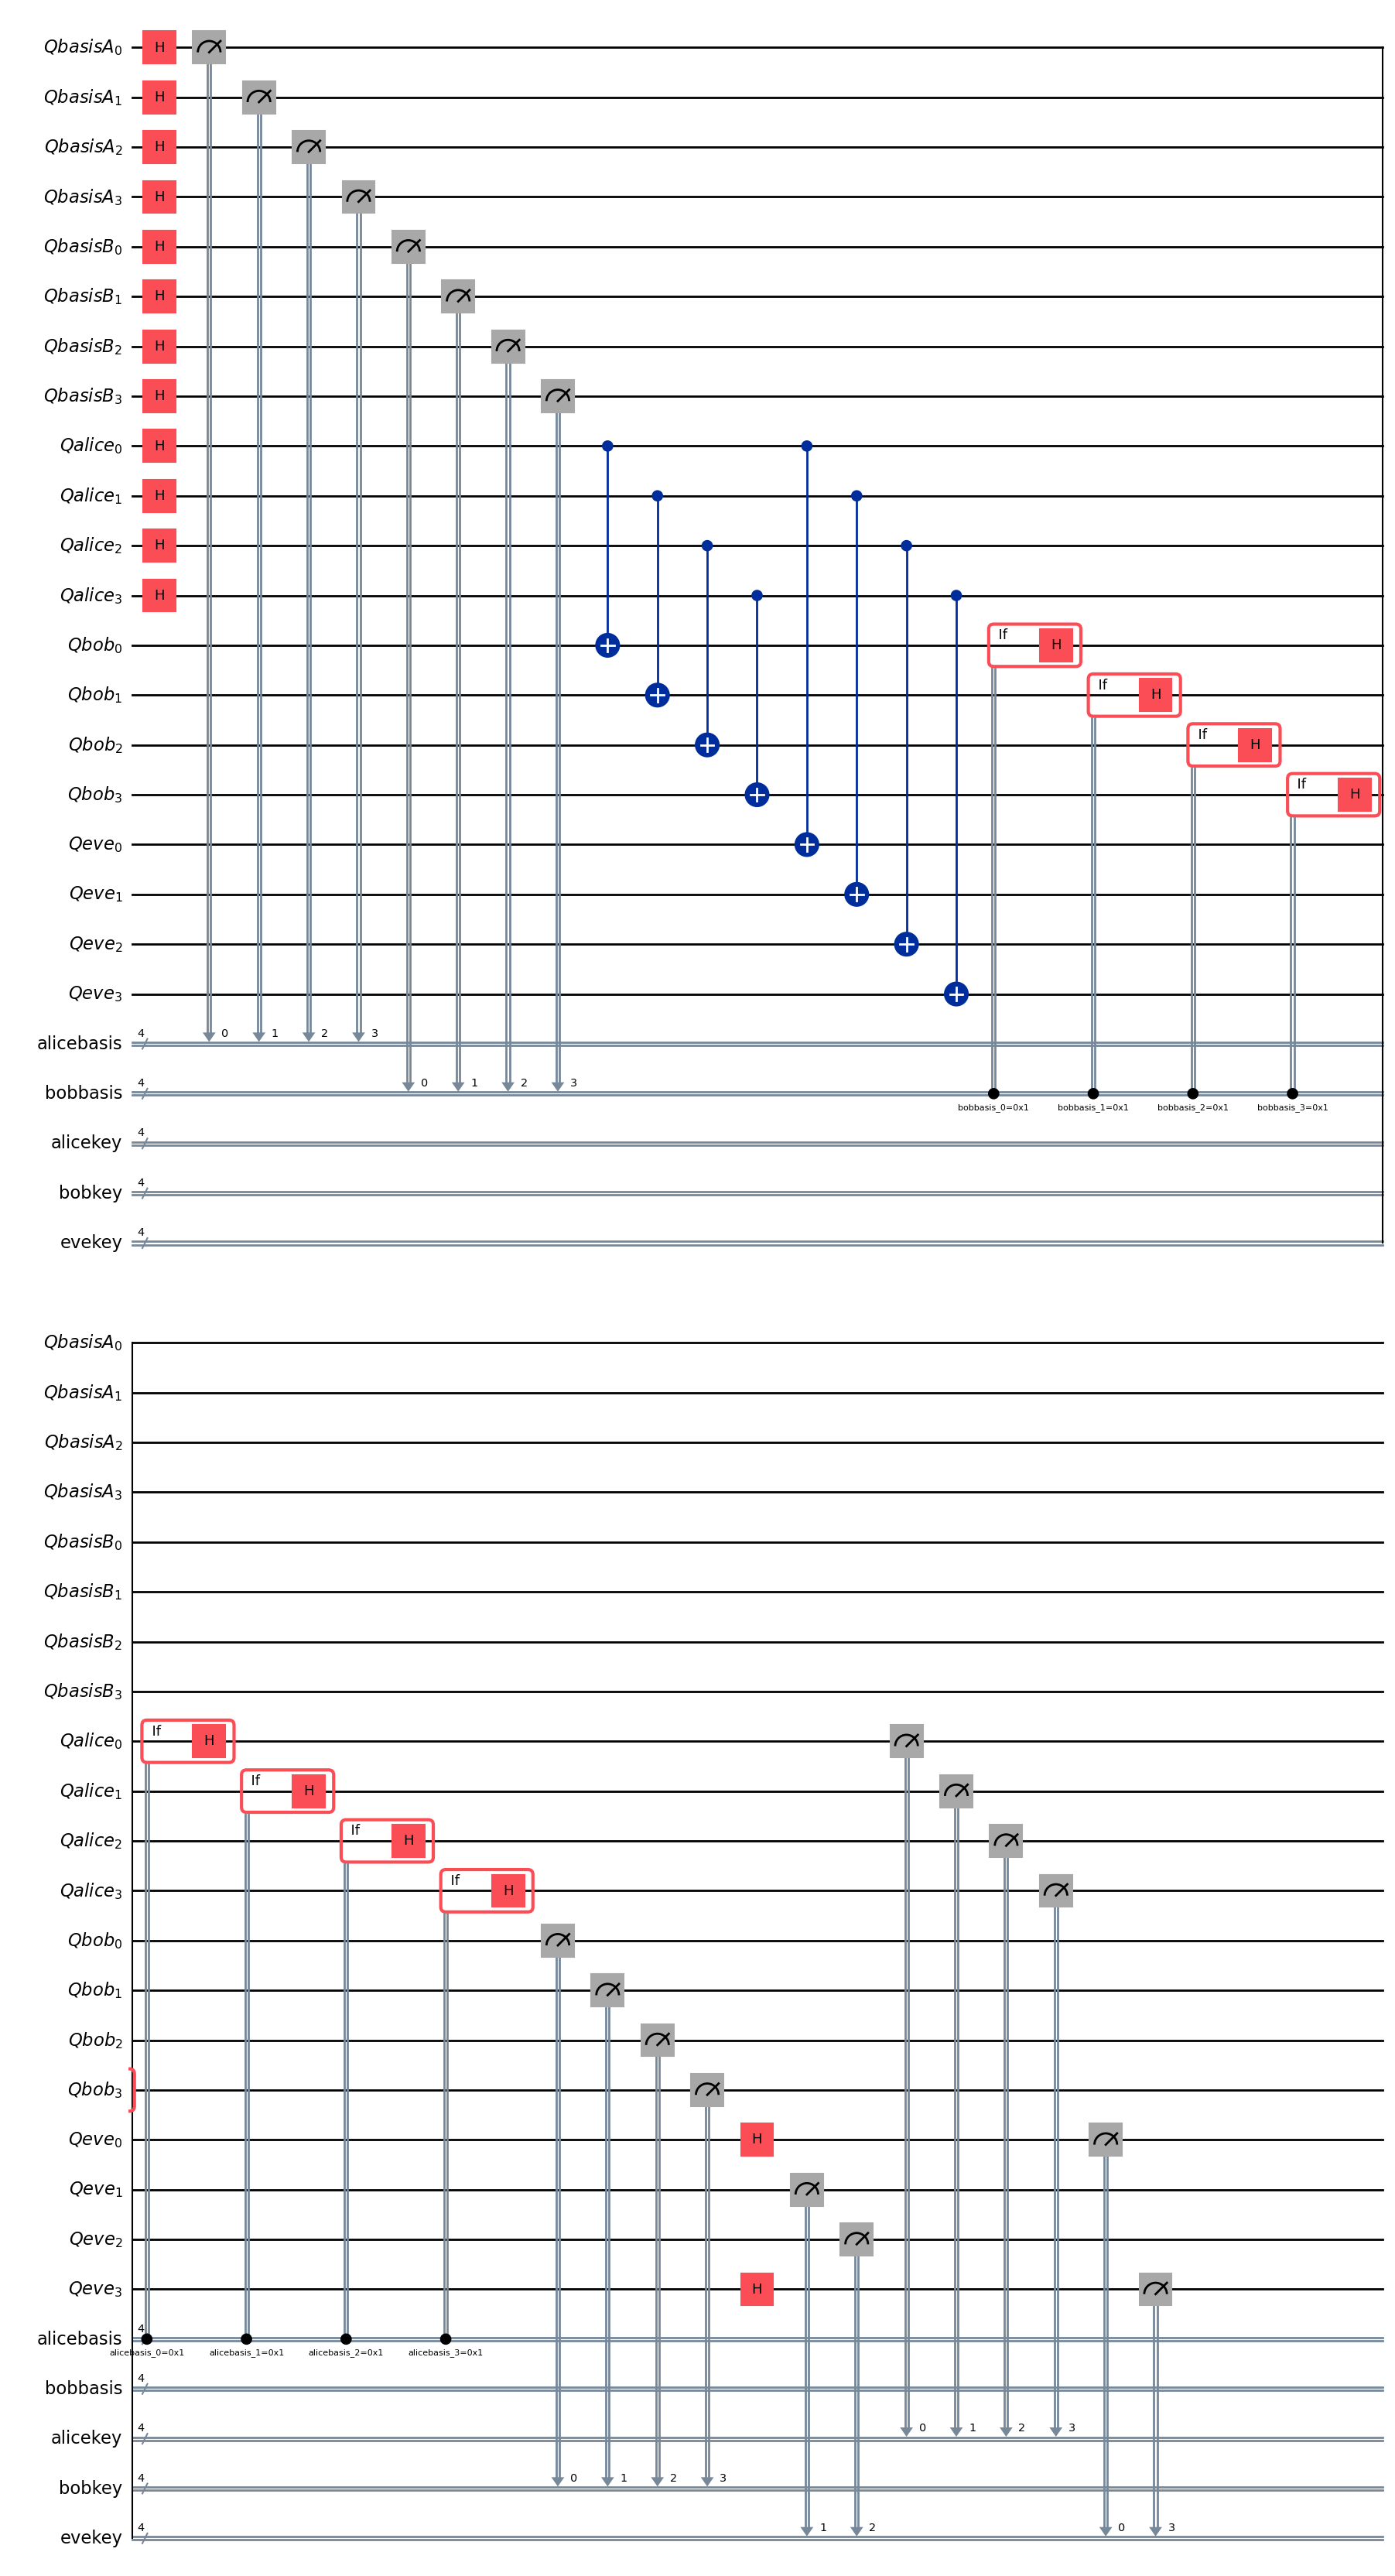

In [32]:
paircounts=4
alicebasisCbit= ClassicalRegister(paircounts,name='alicebasis')
bobbasisCbit= ClassicalRegister(paircounts,name='bobbasis')

alicebasisQbit= QuantumRegister(paircounts,name='QbasisA')
bobbasisQbit= QuantumRegister(paircounts, name='QbasisB')

alicekeyqbit=QuantumRegister(paircounts,name='Qalice') 
bobkeyqbit= QuantumRegister(paircounts, name='Qbob')

alicekeyCbit= ClassicalRegister(paircounts, name='alicekey')
bobkeyCbit= ClassicalRegister(paircounts, name='bobkey')

evekeyQbit= QuantumRegister(paircounts,name='Qeve')
evekeyCbit=ClassicalRegister(paircounts,name='evekey')
qc= QuantumCircuit(alicebasisQbit,bobbasisQbit,alicekeyqbit,bobkeyqbit,alicebasisCbit, bobbasisCbit, alicekeyCbit, bobkeyCbit,evekeyQbit,evekeyCbit)

qc.h(alicebasisQbit)
qc.measure(alicebasisQbit,alicebasisCbit)

qc.h(bobbasisQbit)
qc.measure(bobbasisQbit,bobbasisCbit)

qc.h(alicekeyqbit)
qc.cx(alicekeyqbit,bobkeyqbit)

inject_quantum_eve= True

if inject_quantum_eve:
    qc.cx(alicekeyqbit,evekeyQbit)

# basis for alice and bob , 0 = Z,  1= X, So another H is done for if_test=1 
for i in range(paircounts):
    with qc.if_test((alicebasisCbit[i],1)) as else_:
        qc.h(alicekeyqbit[i])

for i in range(paircounts):
    with qc.if_test((bobbasisCbit[i],1)) as else_:
        qc.h(bobkeyqbit[i])    

qc.measure(alicekeyqbit, alicekeyCbit)
qc.measure(bobkeyqbit,bobkeyCbit)

if inject_quantum_eve:
        for i in range(paircounts):
            # Eve chooses her measurement basis randomly
            if random.randint(0, 1) == 1:
                qc.h(evekeyQbit[i])
        qc.measure(evekeyQbit, evekeyCbit)
qc.draw('mpl')

In [33]:
#service= QiskitRuntimeService(name="qiskit_adi")
#backend = service.least_busy(operational=True, simulator=False)

backend= AerSimulator()
pm = generate_preset_pass_manager(backend = backend, optimization_level=3)
qc_isa = pm.run(qc)

# run and get counts
sampler = Sampler(mode=backend)
results = sampler.run([qc_isa], shots = 2048).result()[0].data



In [34]:
alicebasisdict= results.alicebasis.get_bitstrings()
bobbasisdict= results.bobbasis.get_bitstrings()

alicekeydict= results.alicekey.get_bitstrings()
bobkeydict= results.bobkey.get_bitstrings()

alicebasis=""
bobbasis=""

alicekey=""
bobkey=""

for element in alicebasisdict:
    alicebasis+= element

for element in bobbasisdict:
    bobbasis+= element

for element in alicekeydict:
    alicekey+= element

for element in bobkeydict:
    bobkey+= element


In [35]:
def filter_keys_by_basis(alicekey, bobkey, Alicebasis, Bobbasis):
    """Remove bits where basis isn't the same from keys"""
    finalbasis = ""
    filtered_alicekey = ""
    filtered_bobkey = ""
    
    for i in range(len(Alicebasis)):
        if Alicebasis[i] == Bobbasis[i]:
            filtered_alicekey += alicekey[i]
            filtered_bobkey += bobkey[i]
            finalbasis += Alicebasis[i]
    
    return filtered_alicekey, filtered_bobkey, finalbasis


In [36]:
# VVV --- ADD THIS DEBUGGING BLOCK --- VVV

print("\n--- RUNNING BACKEND SANITY CHECK ---")
    
# Step 1: Sift the keys using the known bases, just like the frontend does.
sifted_alice, sifted_bob, _ = filter_keys_by_basis(alicekey, bobkey, alicebasis, bobbasis)

# Step 2: Compare the two sifted keys to check for mismatches.
mismatches = 0

if len(sifted_alice) != len(sifted_bob):
    print("❌ FATAL ERROR: Sifted keys have different lengths!")
else:
    for i in range(len(sifted_alice)):
        if sifted_alice[i] != sifted_bob[i]:
            mismatches += 1
    
if mismatches > 0:
    error_rate = (mismatches / len(sifted_alice)) * 100
    print(f"❌ BUG CONFIRMED: Found {mismatches} mismatches in the generated keys.")
    print(f"   This is a Quantum Bit Error Rate (QBER) of {error_rate:.2f}%")
else:
    print("✅ SUCCESS: Keys are perfectly correlated. The bug is not in the generation script.")

# ^^^ --- END OF DEBUGGING BLOCK --- ^^^





--- RUNNING BACKEND SANITY CHECK ---
❌ BUG CONFIRMED: Found 994 mismatches in the generated keys.
   This is a Quantum Bit Error Rate (QBER) of 24.45%
